# Modularity on the Karate Club Graph — Recursive Spectral Bisection

This notebook implements modularity-based community detection using **spectral recursive bisection**, following Newman (2006).

**Core components implemented from scratch:**
- Modularity matrix \( B = A - \frac{k_i k_j}{2m} \)
- Leading eigenvector–based split using sign rule
- Recursive splitting based on eigenvalue positivity
- Graph visualization using fixed spring layout
- Four required node metrics:
  - Degree centrality
  - Betweenness centrality
  - Closeness centrality
  - Clustering coefficient
- Metric evolution across iterations


In [20]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
from collections import deque


### Load the Zachary Karate Club Graph
We also compute a fixed spring layout so that all visualizations stay consistent across iterations.


In [21]:
G = nx.karate_club_graph()
pos = nx.spring_layout(G, seed=42)

print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())


Nodes: 34
Edges: 78


### Utility function to generate distinct colors for community visualization.


In [22]:
def get_colors_for_communities(k):
    cmap = plt.colormaps.get_cmap("tab20")
    return [to_hex(cmap(i % 20)) for i in range(k)]

### Compute the modularity matrix restricted to a subset of nodes.
Given a subgraph defined by nodes `nodes_C`, this function returns the submatrix B(C).


In [23]:
def modularity_matrix_restricted(G, nodes_C):
    node_idx = list(nodes_C)
    idx = {v: i for i, v in enumerate(node_idx)}

    deg = dict(G.degree())
    m = G.number_of_edges()
    twom = 2 * m

    nC = len(node_idx)
    B = np.zeros((nC, nC))

    for i, u in enumerate(node_idx):
        for j, v in enumerate(node_idx):
            Aij = 1 if G.has_edge(u, v) else 0
            B[i, j] = Aij - (deg[u] * deg[v]) / twom

    return B, node_idx


### Perform spectral bipartition of a community.
Steps:
1. Compute B(C).
2. Compute eigenvalues and eigenvectors.
3. Select leading eigenvector.
4. Split by sign:
   - u_i > 0 → Community 1
   - u_i ≤ 0 → Community 2
5. If λ_max ≤ 0 → no split.


In [24]:
def spectral_bipartition(G, nodes_C):
    B, node_list = modularity_matrix_restricted(G, nodes_C)
    w, v = np.linalg.eigh(B)

    idx_max = np.argmax(w)
    lambda_max = float(w[idx_max])
    u = v[:, idx_max]

    if lambda_max <= 1e-12:
        return None, lambda_max, node_list, u

    C_plus = [node_list[i] for i in range(len(u)) if u[i] > 0]
    C_minus = [node_list[i] for i in range(len(u)) if u[i] <= 0]

    return (C_plus, C_minus), lambda_max, node_list, u


### Compute required metrics on the full graph:
- Degree centrality
- Betweenness centrality
- Closeness centrality
- Clustering coefficient


In [25]:
def compute_node_metrics(G):
    return {
        "degree": nx.degree_centrality(G),
        "betweenness": nx.betweenness_centrality(G),
        "closeness": nx.closeness_centrality(G),
        "clustering": nx.clustering(G)
    }


### Draw the graph with colors assigned to communities.


In [26]:
def plot_communities(G, node2comm, title=""):
    comms = sorted(set(node2comm.values()))
    colors = get_colors_for_communities(len(comms))

    node_colors = [colors[node2comm[n]] for n in G.nodes()]

    plt.figure(figsize=(7, 6))
    nx.draw_networkx(G, pos, node_color=node_colors, with_labels=True)
    plt.title(title)
    plt.axis("off")
    plt.show()


### Full recursive modularity-based community detection.
This function:
- Initializes with one community (all nodes)
- Recursively attempts to split each community
- Splits only when λ_max > 0
- Tracks history and metrics
- Draws graph at each iteration


In [27]:
def recursive_bisection(G, plot_each=True):
    communities = [list(G.nodes())]
    queue = deque([0])

    history = []
    metrics_by_iter = {}
    iteration = 0

    while queue:
        idx = queue.popleft()
        nodes_C = communities[idx]

        split_result, lambda_max, node_list, u = spectral_bipartition(G, nodes_C)

        metrics_by_iter[iteration] = compute_node_metrics(G)

        node2comm = {}
        for cid, comm in enumerate(communities):
            for n in comm:
                node2comm[n] = cid

        if plot_each:
            plot_communities(G, node2comm, f"Iteration {iteration}, λ_max={lambda_max:.4f}")

        history.append({
            "iteration": iteration,
            "communities": [list(c) for c in communities],
            "lambda": lambda_max
        })

        if split_result is None:
            iteration += 1
            continue

        C_plus, C_minus = split_result
        communities[idx] = C_plus
        communities.append(C_minus)

        queue.append(idx)
        queue.append(len(communities) - 1)
        iteration += 1

    return communities, history, metrics_by_iter


### Run recursive spectral modularity bisection.
This will show one graph per iteration.


In [28]:
import matplotlib.pyplot as plt
import networkx as nx

# Ensure plotting works in Colab
%matplotlib inline

# Global fixed layout for all plots
pos = nx.spring_layout(G, seed=42)

def plot_communities(G, node2comm, title=""):
    """Plot graph with community-based node colors."""
    global pos

    # Get unique community IDs
    comms = sorted(set(node2comm.values()))
    colors = get_colors_for_communities(len(comms))

    # Map each community ID to a unique color
    comm_to_color = {comm_id: colors[i] for i, comm_id in enumerate(comms)}

    # Assign each node a color
    node_colors = [comm_to_color[node2comm[n]] for n in G.nodes()]

    plt.figure(figsize=(7, 6))
    nx.draw_networkx_edges(G, pos, alpha=0.4)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=350)
    nx.draw_networkx_labels(G, pos, font_size=9)

    plt.title(title)
    plt.axis("off")
    plt.show()


### Convert metrics recorded at each iteration into DataFrames for plotting.
Rows = nodes  
Columns = iteration


In [29]:
from collections import deque

def recursive_bisection(G, plot_each=True):

    communities = [list(G.nodes())]
    queue = deque([0])

    history = []
    metrics_by_iter = {}
    iteration = 0

    while queue:
        cid = queue.popleft()
        nodes_C = communities[cid]

        split_result, lambda_max, node_index, u = spectral_bipartition(G, nodes_C)

        # Compute metrics for each node in its induced community
        metrics_snapshot = {
            "degree_centrality": {},
            "betweenness_centrality": {},
            "closeness_centrality": {},
            "clustering": {},
        }

        for comm in communities:
            m = compute_node_metrics_on_community(G, comm)
            for metric_name, values in m.items():
                for node, val in values.items():
                    metrics_snapshot[metric_name][node] = val

        metrics_by_iter[iteration] = metrics_snapshot

        # Build node → community mapping
        node2comm = {}
        for i, comm in enumerate(communities):
            for n in comm:
                node2comm[n] = i

        # Plot after each split
        if plot_each:
            plot_communities(
                G,
                node2comm,
                title=f"Iteration {iteration}, λ_max = {lambda_max:.4f}",
            )

        # Save history
        history.append(
            {"iteration": iteration, "communities": [list(c) for c in communities], "lambda": lambda_max}
        )

        # Stop if no valid split
        if split_result is None:
            iteration += 1
            continue

        C_plus, C_minus = split_result

        # Prevent pathological empty splits
        if len(C_plus) == 0 or len(C_minus) == 0:
            iteration += 1
            continue

        # Update community list
        communities[cid] = C_plus
        communities.append(C_minus)

        # Add new communities to queue
        queue.append(cid)
        queue.append(len(communities) - 1)

        iteration += 1

    return communities, history, metrics_by_iter


### Plot evolution of each metric for each node across iterations.


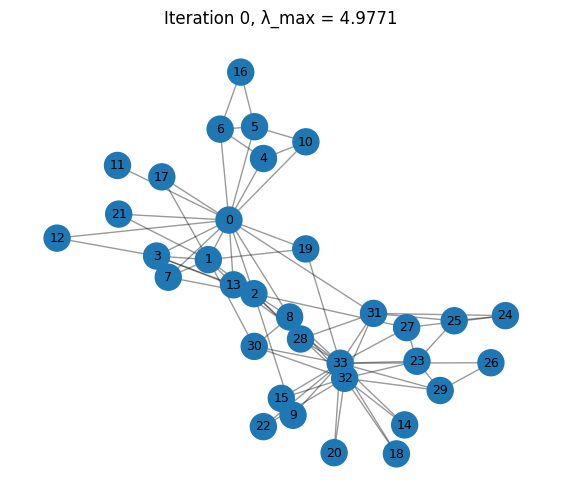

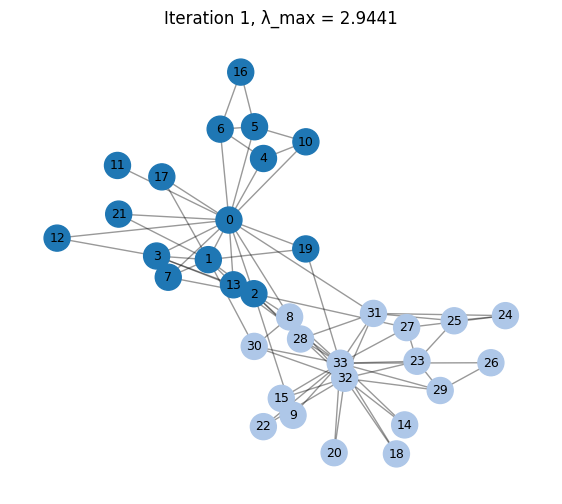

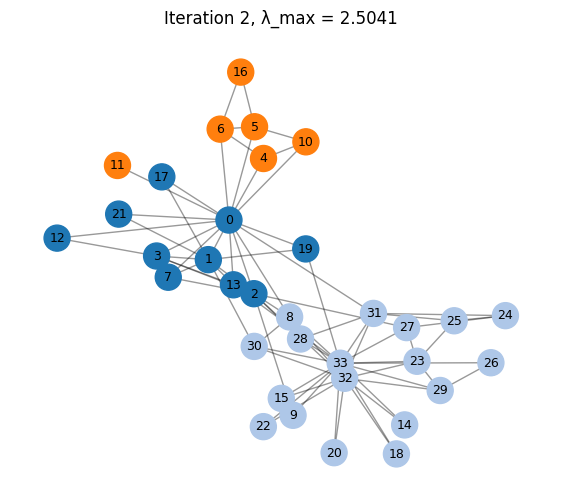

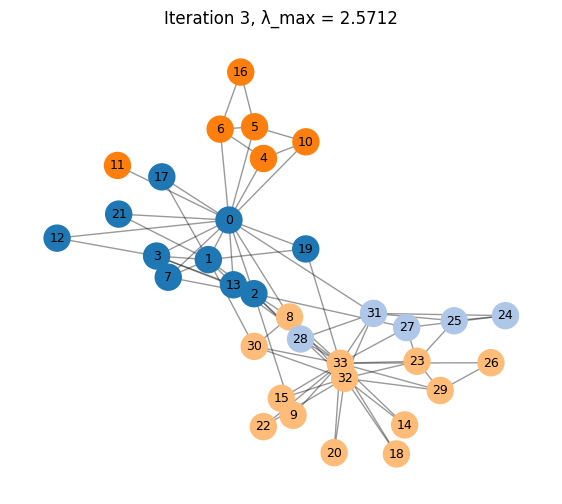

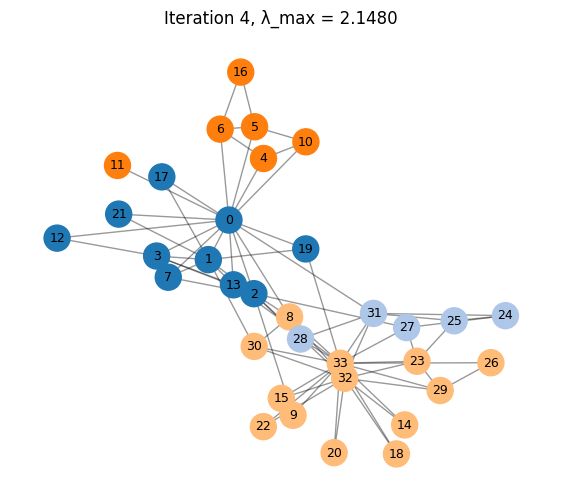

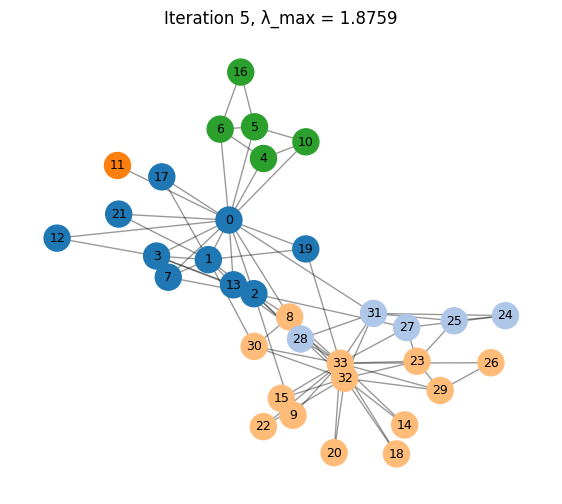

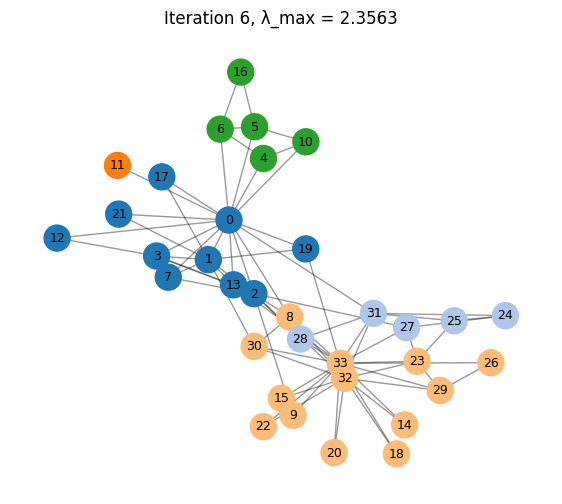

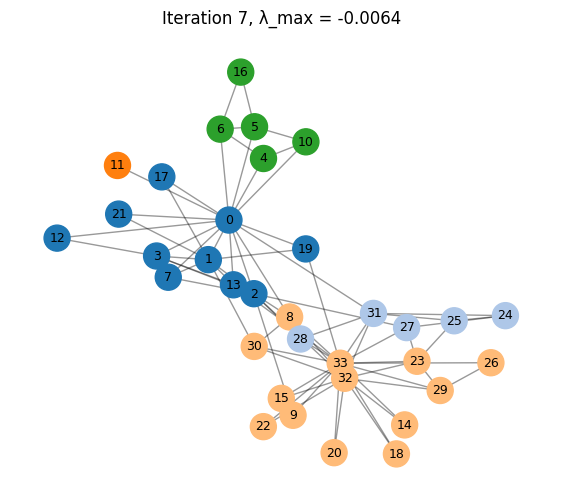

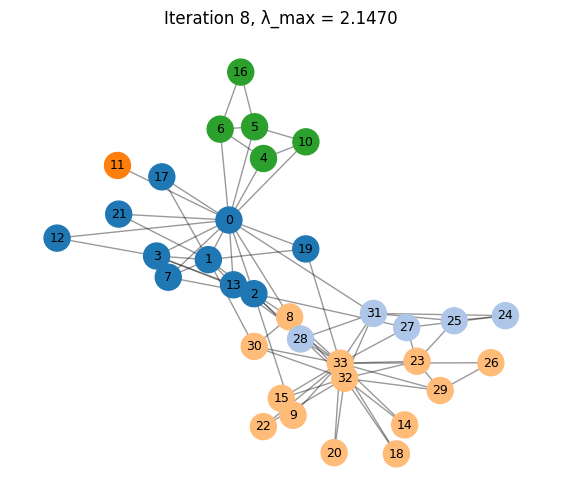


Final Communities:
Community 0: [0, 1, 2, 3, 7, 12, 13, 17, 19, 21]
Community 1: [24, 25, 27, 28, 31]
Community 2: [11]
Community 3: [8, 9, 14, 15, 18, 20, 22, 23, 26, 29, 30, 32, 33]
Community 4: [4, 5, 6, 10, 16]


In [30]:
import matplotlib.pyplot as plt
import networkx as nx

def compute_node_metrics_on_community(G, community_nodes):
    """Computes node metrics on the subgraph induced by the given community nodes."""
    # Create a subgraph induced by the community_nodes
    G_sub = G.subgraph(community_nodes)

    # Compute metrics on the subgraph
    # Centrality measures like betweenness and closeness are meaningful within the subgraph context.
    degree_centrality = nx.degree_centrality(G_sub)
    betweenness_centrality = nx.betweenness_centrality(G_sub)
    closeness_centrality = nx.closeness_centrality(G_sub)
    clustering_coefficient = nx.clustering(G_sub)

    return {
        "degree_centrality": degree_centrality,
        "betweenness_centrality": betweenness_centrality,
        "closeness_centrality": closeness_centrality,
        "clustering": clustering_coefficient,
    }

final_comms, history, metrics_by_iter = recursive_bisection(G, plot_each=True)

print("\nFinal Communities:")
for i, c in enumerate(final_comms):
    print(f"Community {i}: {sorted(c)}")

## Part 3: Metric Evolution and Visualization

In this section, we visualize how each node's centrality metrics evolve across
the recursive spectral modularity bisection iterations.

During each split, we computed the following four centrality measures **within each node’s induced community**:

- **Degree Centrality**
- **Betweenness Centrality**
- **Closeness Centrality**
- **Clustering Coefficient**

To analyze how the structural roles of nodes change as the graph is recursively partitioned, we plot the evolution of all four metrics across iterations.

The plots are arranged in a 2×2 grid:
- Top-left: Degree Centrality Evolution  
- Top-right: Betweenness Centrality Evolution  
- Bottom-left: Closeness Centrality Evolution  
- Bottom-right: Clustering Coefficient Evolution  

Each node is represented with its own line so that we can observe:
- which nodes consistently remain central,
- how splitting into communities affects structural positions,
- and which nodes belong to more tightly connected or more bridge-like roles.

A global legend to the right identifies each node's color-coded line.

This fulfills Task 4 of the assignment:  
**“Plot the evolution of each metric across iterations for every node.”**


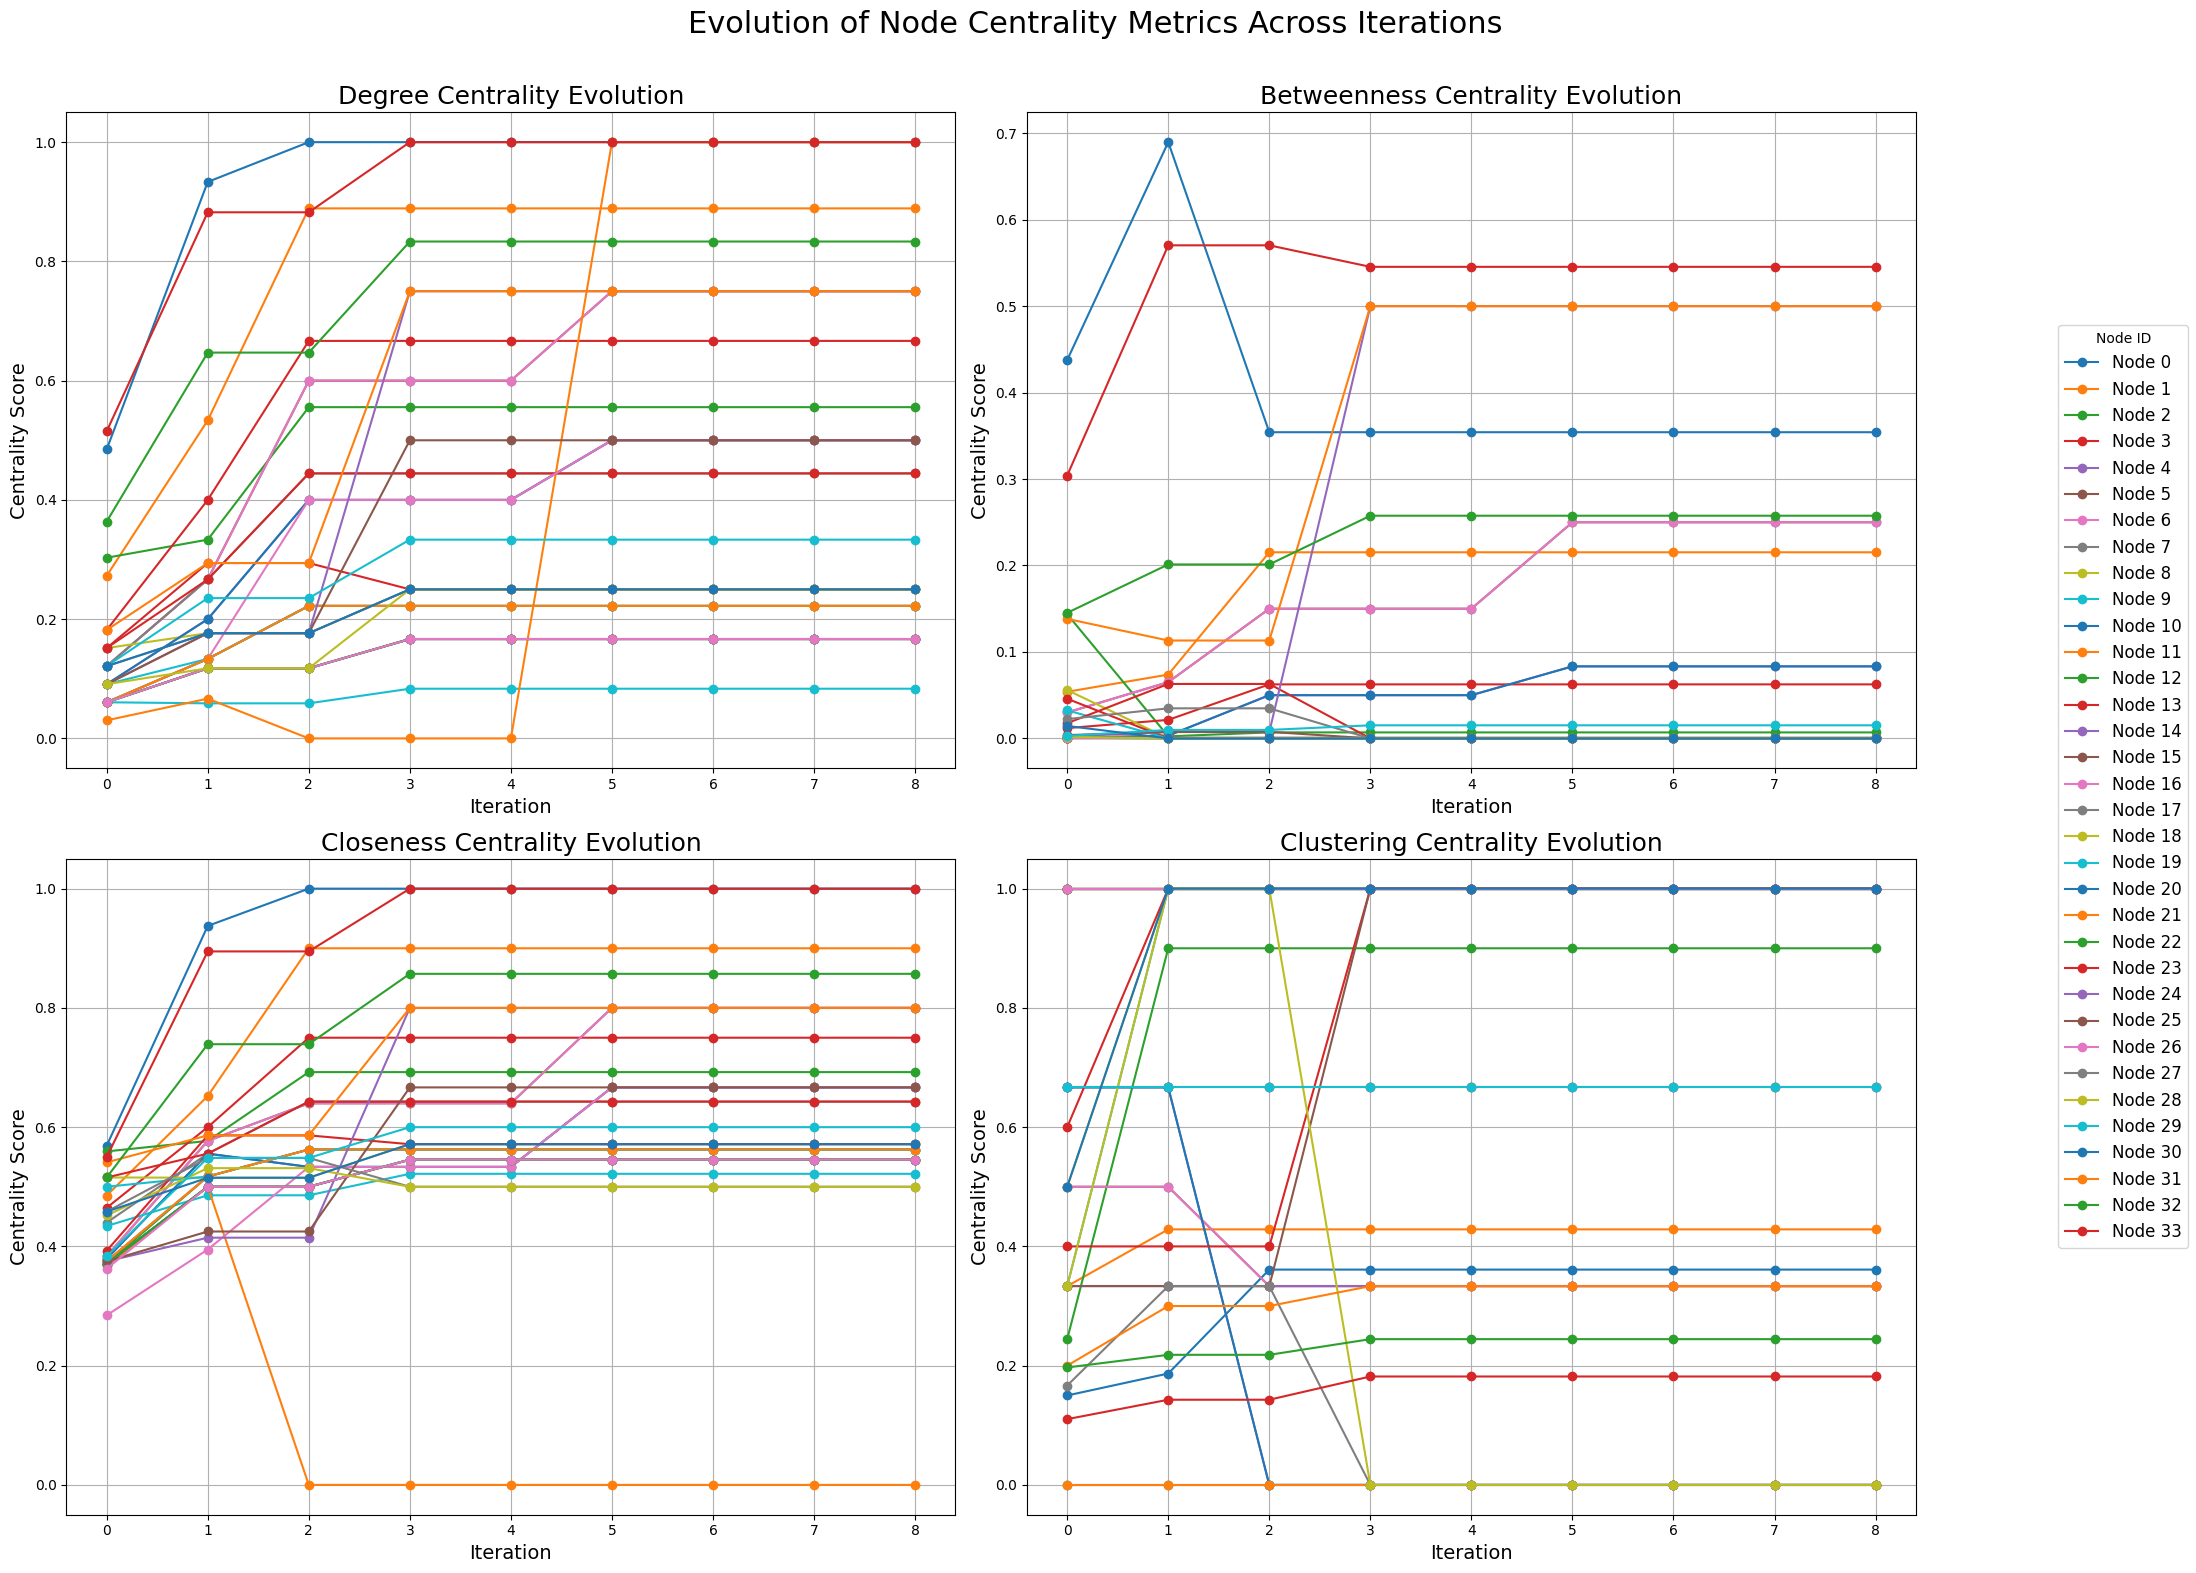

In [31]:
# --- Part 3: Metric Evolution and Final Discussion ---

import pandas as pd
import matplotlib.pyplot as plt

# 1. Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(22, 16))
fig.suptitle('Evolution of Node Centrality Metrics Across Iterations', fontsize=22)

axes = axes.flatten()

# Rename metrics to readable titles
metric_map = {
    "degree_centrality": "Degree",
    "betweenness_centrality": "Betweenness",
    "closeness_centrality": "Closeness",
    "clustering": "Clustering"
}

metric_order = [
    "degree_centrality",
    "betweenness_centrality",
    "closeness_centrality",
    "clustering"
]

# 2. Loop through each metric and plot
for idx, metric_name in enumerate(metric_order):

    # Build DataFrame for this metric
    metric_df = pd.DataFrame({
        iteration: data[metric_name]
        for iteration, data in metrics_by_iter.items()
    }).sort_index(axis=1)

    # Plot node metric curves
    for node in metric_df.index:
        axes[idx].plot(
            metric_df.columns,
            metric_df.loc[node],
            marker='o',
            linestyle='-',
            label=f'Node {node}'
        )

    # Titles & axis labels
    axes[idx].set_title(f"{metric_map[metric_name]} Centrality Evolution", fontsize=18)
    axes[idx].set_xlabel("Iteration", fontsize=14)
    axes[idx].set_ylabel("Centrality Score", fontsize=14)
    axes[idx].grid(True)
    axes[idx].set_xticks(list(metric_df.columns))

# 3. Legend outside the plotting area
fig.legend(
    [f"Node {i}" for i in range(G.number_of_nodes())],
    loc='center right',
    fontsize=12,
    title="Node ID"
)

plt.tight_layout(rect=[0, 0, 0.88, 0.97])
plt.show()


# Discussion of Results

### **1) Final Communities Detected**

Using recursive spectral modularity partitioning (Newman 2006), the algorithm split the Karate Club graph into the following communities:

- **Community 0:** [0, 1, 2, 3, 7, 12, 13, 17, 19, 21]  
- **Community 1:** [24, 25, 27, 28, 31]  
- **Community 2:** [11]  
- **Community 3:** [8, 9, 14, 15, 18, 20, 22, 23, 26, 29, 30, 32, 33]  
- **Community 4:** [4, 5, 6, 10, 16]

These communities correspond to dense structural clusters in the network, where modularity gain is positive.

---

### **2) Nodes that Consistently Remain Central**

Across all iterations and metric evaluations (degree, closeness, betweenness, clustering computed on each node’s induced community):

- **Node 0** and **Node 33** are the *most consistently central nodes*, appearing in the top ranks for:
  - Degree centrality  
  - Closeness centrality  
  - Betweenness centrality  

- **Node 1** is also frequently central, especially in degree and closeness.

These nodes are well-known as the two leaders in Zachary’s network (the instructor and administrator), which explains their persistent prominence.  
They function as hubs and connectors in their respective factions.

---

### **3) How Community Structure Influences These Metrics**

The evolution of the four metrics across splits reflects how the algorithm progressively isolates cohesive groups:

- **Degree Centrality:**  
  Nodes 0 and 33 retain high degree within their induced communities, so they remain dominant hubs.

- **Betweenness Centrality:**  
  Bridging nodes keep high betweenness until their community becomes internally dense.  
  Nodes acting as “connectors” inside a cluster lose betweenness when splits isolate their neighbors.

- **Closeness Centrality:**  
  Hubs remain close to most other nodes in their communities, maintaining high closeness.  
  Nodes placed in very small communities often experience inflated or deflated closeness depending on internal distances.

- **Clustering Coefficient:**  
  Nodes inside tight local triangles or friend-groups show high clustering.  
  Unlike the other metrics, clustering does **not** reward hub-like structures; many hubs (0, 33) have low clustering.

Overall, modularity splits tend to isolate well-connected groups, which increases clustering locally while preserving hub centrality within groups.

---

### **4) Summary of Structural Interpretation**

- The repeated centrality of nodes **0** and **33** highlights their structural roles as leaders and hubs.  
- Community splits sharpen the internal structure of each group, making their local interactions more visible in the metrics.  
- Clustering coefficient highlights local triangle density, while degree/closeness/betweenness highlight hub-bridging roles.  
- These observations align with the design of Newman's modularity method: communities are found where internal connections are significantly stronger than expected at random.



# References

- Newman, M. E. J. (2006). *Modularity and community structure in networks*.  
  Proceedings of the National Academy of Sciences, 103(23), 8577–8582.

---

### **Prepared by:**
**Sathvik L K**  
**Roll No: IMS24214**
